In [2]:
import pandas as pd

In [3]:
merged2=pd.read_csv('/lustre/scratch126/cellgen/team298/ab72/accelerate/WATER_METADATA_PHYTOPLANKTON.csv')

/tmp/ipykernel_1101469/3671086491.py:1: DtypeWarning: Columns (23,24,33,35,39,40,41,42,43,44,45,46,47,48,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  merged2=pd.read_csv('/lustre/scratch126/cellgen/team298/ab72/accelerate/WATER_METADATA_PHYTOPLANKTON.csv')


In [4]:
subset_pandas = merged2[merged2["siteid"] == "E-A10HS"]

#  Display the subset
print(subset_pandas.head())

    siteid                                    sitename country        seaname  \
0  E-A10HS  Ondarroa (Embarcadero). High Tide. Surface      ES  Bay of Biscay   
1  E-A10HS  Ondarroa (Embarcadero). High Tide. Surface      ES  Bay of Biscay   
2  E-A10HS  Ondarroa (Embarcadero). High Tide. Surface      ES  Bay of Biscay   
3  E-A10HS  Ondarroa (Embarcadero). High Tide. Surface      ES  Bay of Biscay   
4  E-A10HS  Ondarroa (Embarcadero). High Tide. Surface      ES  Bay of Biscay   

   decimallatitude  decimallongitude datecollected  Temperature    pH  \
0        43.319883         -2.420973    2002-04-24         16.5  8.34   
1        43.319883         -2.420973    2002-04-24         16.5  8.34   
2        43.319883         -2.420973    2002-04-24         16.5  8.34   
3        43.319883         -2.420973    2002-04-24         16.5  8.34   
4        43.319883         -2.420973    2002-04-24         16.5  8.34   

   Dissolved oxygen  ...        sampleid   basisofrecord  \
0             

In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 📌 Aggregate environmental factors per `sampleid`
env_factors = subset_pandas.groupby("sampleid")[["Temperature", "pH", "Dissolved oxygen", "Salinity"]].mean().reset_index()

# 📌 Drop duplicate environmental factor columns before merging
subset_pandas_cleaned = subset_pandas.drop(columns=["Temperature", "pH", "Dissolved oxygen", "Salinity"])

# 📌 Merge cleaned data with environmental factors
df_merged = subset_pandas_cleaned.merge(env_factors, on="sampleid", how="left")

# 📌 Encode `taxaname` as a categorical feature
le = LabelEncoder()
df_merged["taxaname_encoded"] = le.fit_transform(df_merged["taxaname"])

# 📌 Select features (Temperature, pH, etc.)
X = df_merged[["Temperature", "pH", "Dissolved oxygen", "Salinity", "taxaname_encoded"]]
y = df_merged["parameter_value"]

# 📌 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_merged["taxaname_encoded"])

# 📌 Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

# 📌 Predict and Evaluate
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"XGBoost RMSE: {rmse}")


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [20]:
#  Count occurrences of each species
species_counts = df_merged["taxaname_encoded"].value_counts()

# Keep only species that appear at least twice
valid_species = species_counts[species_counts >= 2].index
df_filtered = df_merged[df_merged["taxaname_encoded"].isin(valid_species)]

# Train-Test Split (Now Without Rare Species)
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered[["Temperature", "pH", "Dissolved oxygen", "Salinity"]],
    df_filtered["parameter_value"],
    test_size=0.2,
    random_state=42,
    stratify=df_filtered["taxaname_encoded"]  # No more single-instance classes
)


In [21]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.001, max_depth=4)
xgb_model.fit(X_train, y_train)

#  Predict and Evaluate
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"XGBoost RMSE: {rmse}")


XGBoost RMSE: 90.99473262941949


In [13]:
#  Count occurrences of each species
species_counts = df_merged["taxaname_encoded"].value_counts()

#  Keep only species that appear at least twice
valid_species = species_counts[species_counts >= 2].index
df_filtered = df_merged[df_merged["taxaname_encoded"].isin(valid_species)]

#  Train-Test Split (Now Without Rare Species)
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered[["Temperature", "pH"]],
    df_filtered["parameter_value"],
    test_size=0.2,
    random_state=42,
    stratify=df_filtered["taxaname_encoded"]  # No more single-instance classes
)


In [14]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.0001, max_depth=3)
xgb_model.fit(X_train, y_train)

#  Predict and Evaluate
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"XGBoost RMSE: {rmse}")


XGBoost RMSE: 91.80468771886551


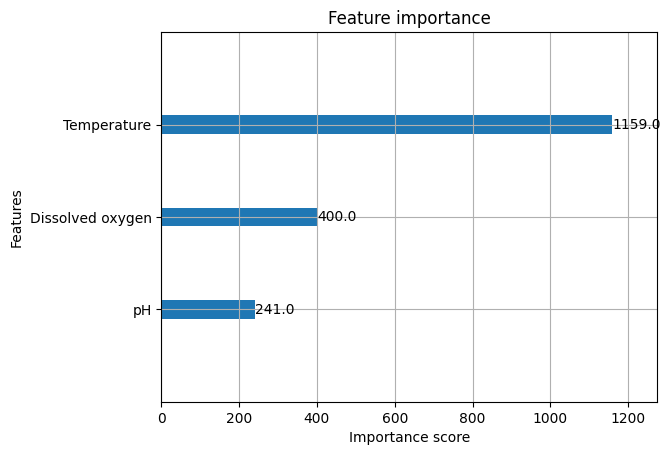

In [22]:
import xgboost as xgb
import matplotlib.pyplot as plt

#  Ensure `model` is the trained XGBoost model
xgb.plot_importance(xgb_model)  
plt.show()
